# Plots for the paper

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib import rcParams
from IPython.display import HTML
import numpy as np
import importlib
import math
from scipy.special import comb
import sys
import time

sys.path.insert(1, '../cswor')
import cswor
importlib.reload(cswor)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=15)

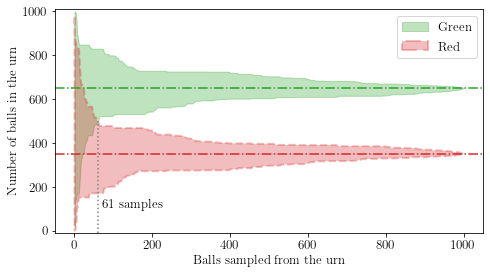

In [67]:
alpha    = 0.05 
N        = 1000
Ta_true  = 650
# Uniform prior
BB_alpha = 1
BB_beta  = 1
n = np.ones(N)

x = np.append(np.ones(Ta_true), np.zeros(N - Ta_true))
np.random.shuffle(x)
t = np.arange(1, len(x) + 1)

CIs_lower_a, CIs_upper_a = cswor.BBHG_confseq(x, N, BB_alpha, BB_beta,
                                              alpha=alpha,
                                              running_intersection=True)

CIs_lower_a = np.array(CIs_lower_a)
CIs_upper_a = np.array(CIs_upper_a)

CIs_lower_b = N - CIs_upper_a
CIs_upper_b = N - CIs_lower_a
# Create confidence sequence plots
plt.figure(figsize=(7, 4))
plt.fill_between(t, CIs_lower_a, CIs_upper_a, color='tab:green',
                 label = "Green", alpha =0.3)
plt.fill_between(t, CIs_lower_b, CIs_upper_b, color='tab:red',
                 linestyle='--', lw=2,
                 label = "Red", alpha = 0.3)
plt.axhline(Ta_true, color='tab:green', linestyle='-.', )
plt.axhline(N-Ta_true, color='tab:red', linestyle='-.', )
# Add vertical line for when the audit can stop
plt.legend(loc = "best")

stopping_time = np.where(CIs_lower_a > N/2)[0][0]
plt.vlines(x = stopping_time,
           color="grey", ymin=-10, ymax=500,
           linestyle = ":")
plt.text(x = stopping_time + 10, 
         y = 100, s = str(stopping_time) + " samples")

plt.ylim(-10, 1010)
plt.xlabel("Balls sampled from the urn")
plt.ylabel("Number of balls in the urn")
plt.tight_layout()
plt.savefig("../figures/twoPartyConfseq.pdf", transparent=True)

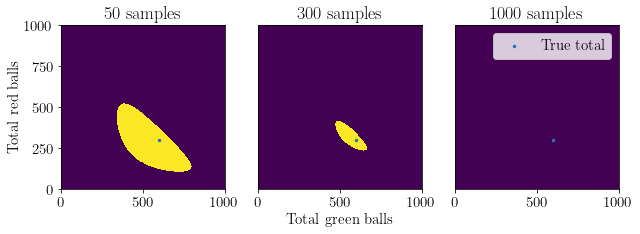

In [14]:
alpha    = 0.05 
R        = 600 
G        = 300
P        = 100
N = R + G + P
# Uniform prior
DM_alpha = [1, 1, 1]
K = len(DM_alpha)
n = np.ones(N)

R_votes = np.array([[1, 0, 0], ] * R).T
G_votes = np.array([[0, 1, 0], ] * G).T
P_votes = np.array([[0, 0, 1], ] * P).T

votes   = np.column_stack((R_votes, G_votes, P_votes))
np.random.shuffle(votes.T)

votes_cumsum = votes.cumsum(axis = 1)

# MLE at each time: N * x_cumsum / intrinsic_time
intrinsic_time = votes_cumsum.sum(axis = 0)
T_hats = np.transpose(N * 
                  np.divide(votes_cumsum,
                            intrinsic_time[None, :]))

# Create confidence set sequence plots
c3d = cswor.Confseq3D(N, DM_alpha, alpha, fineness = 0.5)

samples = [50, 300, N] 

cs1 = c3d.update_from_S_t(votes_cumsum[:, samples[0]-1])
cs2 = c3d.update_from_S_t(votes_cumsum[:, samples[1]-1])
cs3 = c3d.update_from_S_t(votes_cumsum[:, samples[2]-1])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3.5))
ax1.imshow(cs1, 
           interpolation = 'none', extent = [0, N, N, 0])
ax1.set_title(str(samples[0]) + " samples")
ax2.imshow(cs2, 
           interpolation = 'none', extent = [0, N, N, 0])
ax2.set_title(str(samples[1]) + " samples")
ax2.axes.get_yaxis().set_visible(False)
ax3.imshow(cs3, 
           interpolation = 'none', extent = [0, N, N, 0])
ax3.set_title(str(samples[2]) + " samples")
ax3.axes.get_yaxis().set_visible(False)

ax1.set(ylabel = 'Total red balls')
ax2.set(xlabel = 'Total green balls')

s = 6

ax1.scatter(R, G, label = "True total",
            s = s, color = "tab:blue")
ax2.scatter(R, G, label = "True total",
            s = s, color = "tab:blue")
ax3.scatter(R, G, label = "True total",
            s = s, color = "tab:blue")
ax3.legend(loc = "best")

plt.setp((ax1, ax2, ax3), xlim=(0, N+1), ylim=(0, N+1))

#Only save the figure when we want to update it
plt.savefig("../figures/threePartyConfseq.pdf", bbox_inches='tight', transparent=True)

0.2871091365814209
0.2929401397705078
0.31972622871398926


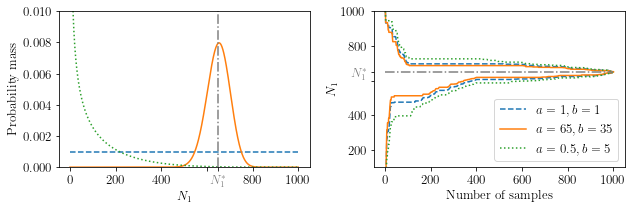

In [68]:
import time
importlib.reload(cswor)
# We'll try out a few different priors.
priors = [(1, 1),(65, 35), (0.5, 5)]
# for plotting the priors
k = np.arange(0, 1001)
k = np.vstack((k, 1000 - k))

# Now let's set up the confidence sequence plots
alpha    = 0.05 
N        = 1000
Tb_true  = 650 

n = np.ones(N)

x = np.append(np.ones(Tb_true), np.zeros(N - Tb_true))
np.random.shuffle(x)

t         = np.cumsum(n)
threshold = np.repeat(alpha, len(t) + 1)

# MLEs for Tb
Ta_hats               = np.append(0, N * np.cumsum(x) / t)

# We want two subplots 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3.1))
plt.rc('font', size=13)

linestyles = {priors[0] : "--", priors[1] : "-", priors[2] : ":"}
for prior in priors: 
    a = np.tile(prior, (1001, 1)).transpose()
    label = "$a = " + str(prior[0]) + \
            ", b = " + str(prior[1]) + "$"
    dm_pmf = np.exp(cswor.dirichlet_multinomial_pmf(k, 1000, a, log_scale = True))
    # Plot beta-binomial pmf
    ax1.plot(dm_pmf, label = label, linestyle=linestyles[prior])

    start=time.time()
    CIs_lower_a, CIs_upper_a = cswor.BBHG_confseq(x, N, prior[0], prior[1],
                                               alpha = alpha,
                                               running_intersection = True)
        
    end=time.time()
    print(end-start)
    # Create confidence sequence plots
    # Very hacky way to make the upper/lower
    # the same color/label 
    p = ax2.plot(t, CIs_lower_a,
                 label = "$a = " + str(prior[0]) +\
                 ", b = " + str(prior[1]) + "$", 
                 linestyle=linestyles[prior])
    ax2.plot(t, CIs_upper_a, color = p[0].get_c(), 
             linestyle=linestyles[prior])
    
xticks=np.append(np.arange(0, 1001, step=200), [650])
xticklabels=["" if t==600 else "$N_1^*$" if t==650 else t for t in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels)
ax1.get_xticklabels()[-1].set_color("grey")
ax1.set_ylim(0, 0.01)
ax1.set(xlabel = "$N_1$")
ax1.set(ylabel = "Probability mass")    
ax1.axvline(x = Tb_true, color = "grey",
            linestyle = "-.", label = "$N_1^*$")

yticks=np.append(np.arange(0, 1001, step=200), [650])
yticklabels=["" if t==600 else "$N_1^*$" if t==650 else t for t in yticks]
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticklabels)
ax2.get_yticklabels()[-1].set_color("grey")
ax2.legend(loc = "best")
ax2.set(xlabel = "Number of samples")
ax2.set(ylabel = "$N_1$")
ax2.plot(t, np.repeat(Tb_true, N), label = "$N_1^*$", color = "gray", linestyle = "-.")
ax2.set_ylim(100, 1000)

plt.tight_layout()
plt.savefig("../figures/betaBinomialConfint.pdf", bbox_inches = "tight", transparent=True)
plt.show()

# Four Motivating Examples

Finished opinions plot
Finished Shapley values plot
Finished permutation p-value plot
Finished test scores plot


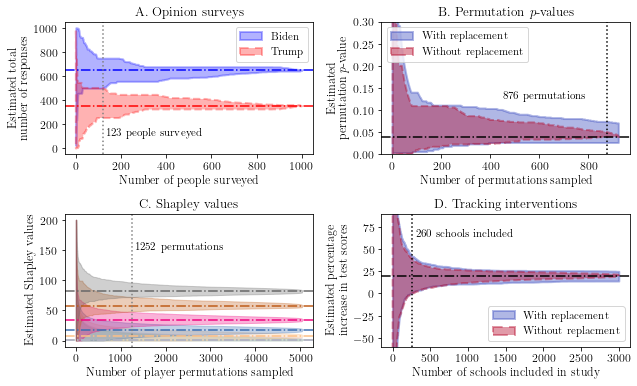

In [16]:
lw=2

import utils
import misc
importlib.reload(utils)
importlib.reload(misc)
importlib.reload(cswor)
fig, ax = plt.subplots(2, 2, figsize = (9, 5.5))
plt.rc('font', size=11)

### Polling ###
alpha    = 0.05 
N        = 1000
Ta_true  = 650 
# Uniform prior
BB_alpha = 1
BB_beta  = 1
n = np.ones(N)

x = np.append(np.ones(Ta_true), np.zeros(N - Ta_true))
np.random.shuffle(x)

# MLEs for Tb
t = np.arange(0, len(x)) + 1
S_t = np.cumsum(x)  
Zstar = np.append([0], S_t)[0:len(S_t)] / (N-(t-1))  
Wstar = np.append([0], t)[0:len(S_t)] / (N-(t-1))  
Ta_hats = N*(np.cumsum(Zstar) + S_t) / (t + np.cumsum(Wstar))
CIs_lower_a, CIs_upper_a = cswor.BBHG_confseq(x, N, BB_alpha, BB_beta,
                                              alpha = alpha,
                                              running_intersection = True)

CIs_lower_a = np.array(CIs_lower_a)
CIs_upper_a = np.array(CIs_upper_a)

Tb_hats = N - Ta_hats
CIs_lower_b = N - CIs_upper_a
CIs_upper_b = N - CIs_lower_a
ax[0][0].fill_between(t, CIs_lower_a, CIs_upper_a,
                      alpha =0.3, label="Biden", 
                      color="blue", linestyle="-", lw=lw)
ax[0][0].fill_between(t, CIs_lower_b, CIs_upper_b,
                      alpha = 0.3, label="Trump",
                      linestyle="--", facecolor="red",
                      edgecolor="red", lw=lw)
ax[0][0].legend(loc = "best")
ax[0][0].axhline(Ta_true,color="blue", linestyle="-.")
ax[0][0].axhline(N-Ta_true,color="red", linestyle="-.")
# Add vertical line for when the audit can stop
stopping_time = np.where(CIs_lower_a > N/2)[0][0]
ax[0][0].axvline(x = stopping_time,
            color="grey", linestyle = ":")
ax[0][0].text(x = stopping_time + 10, 
         y = 100, s = str(stopping_time) + " people surveyed")
ax[0][0].set(xlabel = "Number of people surveyed", 
             ylabel = "Estimated total\nnumber of responses")
ax[0][0].set_title("A. Opinion surveys")

print("Finished opinions plot")
### Shapley values ###
def shapley_value(i, distances):
    distances = np.array(distances)
    N = len(distances)
    
    if i==1:
        return (distances[i-1]/N)
    else:
        first_term = distances[i-1]/(N-i+1)
        indices = np.arange(1, i)
        second_term = np.sum(distances[0:(i-1)]/\
                             ((N-indices+1)*(N-indices)))
        return(first_term - second_term)
distances = np.array([1, 10, 40, 80, 130, 175, 200])
num_trials = math.factorial(len(distances))-1
players = tuple(np.arange(1, len(distances)+1))

assert(num_trials < math.factorial(len(players)))
benefits = np.zeros(num_trials)

colors = cm.Accent(np.linspace(0, 1, len(players)))
t = np.arange(1, num_trials+1)
lower_CIs = [None]*len(distances)
upper_CIs = [None]*len(distances)
for player in np.arange(1, len(players)+1):
    hashes = set()
    for i in np.arange(0, num_trials):
        tuple_i = tuple(np.random.permutation(players))
        while(hash(tuple_i) in hashes):
            tuple_i = tuple(np.random.permutation(players))
        hash_i = hash(tuple_i)
        hashes.add(hash_i)

        where_player = np.where(player==np.array(tuple_i))[0][0]
        group = np.array(tuple_i)[0:(where_player+1)]
        if len(group) == 1:
            benefit = distances[player-1]
        else:
            benefit = np.max(distances[group-1]) -\
                        np.max(distances[group-1][0:(len(group)-1)])
        benefits[i] = benefit
        
    lower, upper = cswor.predmix_hoeffding_wor(benefits, 
                                               lower_bd = 0, 
                                               upper_bd = 201,
                                               N = math.factorial(len(players)),
                                               alpha = 0.05/len(players),
                                               running_intersection=True)


    
    lower_CIs[player-1]=lower
    upper_CIs[player-1]=upper
    
    fb = ax[1][0].fill_between(t, lower, upper, alpha = 0.3, 
                          color = colors[player-1])
    ax[1][0].axhline(shapley_value(player, distances), 
                color = colors[player-1], linestyle="-.")

stopping_time = np.where(lower_CIs[len(players)-1] >\
                         upper_CIs[len(players)-2])[0][0]
ax[1][0].text(s=str(stopping_time) + " permutations", 
              x=stopping_time+70, y=150)
ax[1][0].set(xlabel="Number of player permutations sampled",
             ylabel="Estimated Shapley values")
ax[1][0].axvline(stopping_time, color="grey", linestyle=":")


ax[1][0].set_title("C. Shapley values")
print("Finished Shapley values plot")

### Lady Tasting Tea ###

num_milk = 6
num_tea = 6
milk_success = 10
num_cups = num_milk+num_tea
# 1 means milk first, 0 is tea first
milk_list = np.append(np.ones(num_milk), np.zeros(num_milk))
np.random.shuffle(milk_list)
num_combinations = int(comb(num_cups, num_milk))
num_trials = num_combinations

hashes = set()

assert(num_trials <= num_combinations)

exceed_test_stat = np.zeros(num_trials)
for i in np.arange(0, num_trials):
    random_guess_i = tuple(np.random.permutation(milk_list))
    
    while(hash(random_guess_i) in hashes):
        random_guess_i = tuple(np.random.permutation(milk_list))
    hash_i = hash(random_guess_i)
    hashes.add(hash_i)

    random_success_i = np.sum(random_guess_i == milk_list)
    exceed_test_stat[i] = random_success_i >= milk_success

lower_wor,upper_wor = cswor.BBHG_confseq(exceed_test_stat, n = np.ones(num_trials),
                                         N = num_combinations, BB_alpha = 1, BB_beta = 1,
                                         alpha = 0.05, running_intersection=True)

sample = [np.random.choice(exceed_test_stat) for _ in range(num_trials)]
lower_wr,upper_wr = cswor.BBWR_confseq(sample, n=np.ones(num_trials),
                                         N=num_combinations,
                                         B_alpha=1, B_beta=1,
                                         alpha=0.05, 
                                         running_intersection=True)

t = np.arange(1, num_trials + 1)

colors = cm.coolwarm(np.linspace(0, 1, 2))
ax[0][1].fill_between(t, np.array(lower_wr) / num_combinations, 
                 np.array(upper_wr)/ num_combinations, alpha = 0.4,
                 color = colors[0], label="With replacement", 
                      linestyle="-", lw=lw)
ax[0][1].fill_between(t, np.array(lower_wor) / num_combinations, 
                 np.array(upper_wor)/ num_combinations, alpha = 0.4,
                 color = colors[1], label="Without replacement", 
                      linestyle="--", lw=lw)
ax[0][1].set(ylim=(0, 0.3))
ax[0][1].set(xlabel="Number of permutations sampled",
             ylabel="Estimated\npermutation $p$-value")
stopping_time = np.where(upper_wor/num_combinations < 0.05)[0][0]
ax[0][1].axvline(x = stopping_time, 
            color="black", linestyle = ":")
ax[0][1].text(x = stopping_time-425, 
         y = 0.125, s = str(stopping_time) + " permutations")
ax[0][1].axhline(np.sum(exceed_test_stat)/num_combinations,
            color="black",
            linestyle="-.")
ax[0][1].legend(loc="best")
ax[0][1].set_title("B. Permutation $p$-values")

print("Finished permutation p-value plot")

### Test scores ###

num_schools = 3000
a,b = 3,2
score_increases = 100*np.random.beta(a, b, num_schools)*2-100
mean = np.mean(score_increases)

t_opt = [10, 100, 1000]

lower_wor, upper_wor = cswor.hoeffding_wor(score_increases, lower_bd = -100,
                                          upper_bd = 100, t_opts=[1000],
                                          N = num_schools, alpha = 0.05,
                                          running_intersection=True)
sample = [np.random.choice(score_increases) for _ in range(num_schools)]
lower_wr, upper_wr = cswor.hoeffding_wr_lc_stitch(sample, lower_bd = -100,
                                               upper_bd = 100,
                                               t_opts=[1000],
                                               N = num_schools, alpha = 0.05,
                                               running_intersect=True)

t = np.arange(1, num_schools+1)
colors = cm.coolwarm(np.linspace(0, 1, 2))
ax[1][1].fill_between(t, lower_wr,upper_wr, alpha=0.4,
                 color = colors[0], label = "With replacement", 
                      linestyle="-", lw=lw)
ax[1][1].fill_between(t, lower_wor,upper_wor, alpha=0.4,
                 color = colors[1], label = "Without replacment", 
                      linestyle="--", lw=lw)
ax[1][1].axhline(mean, linestyle = "-.", 
            color = "black")
ax[1][1].set(xlabel="Number of schools included in study",
             ylabel="Estimated percentage\nincrease in test scores")
ax[1][1].set_ylim(-60, 90)
stopping_time = np.where(lower_wor > 0)[0][0]
ax[1][1].axvline(x = stopping_time, 
            color="black", linestyle = ":")
ax[1][1].text(x = stopping_time + 50, 
         y = 65, s = str(stopping_time) + " schools included")
ax[1][1].legend(loc="lower right")

ax[1][1].set_title("D. Tracking interventions")

print("Finished test scores plot")


plt.tight_layout()
plt.savefig("../figures/motivatingExamples.pdf")
plt.show()

In [23]:


num_milk = 6
num_tea = 6
milk_success = 10
num_cups = num_milk+num_tea
# 1 means milk first, 0 is tea first
milk_list = np.append(np.ones(num_milk), np.zeros(num_milk))
np.random.shuffle(milk_list)
num_combinations = int(comb(num_cups, num_milk))
num_trials = num_combinations

hashes = set()

assert(num_trials <= num_combinations)

exceed_test_stat = np.zeros(num_trials)
for i in np.arange(0, num_trials):
    random_guess_i = tuple(np.random.permutation(milk_list))
    
    while(hash(random_guess_i) in hashes):
        random_guess_i = tuple(np.random.permutation(milk_list))
    hash_i = hash(random_guess_i)
    hashes.add(hash_i)

    random_success_i = np.sum(random_guess_i == milk_list)
    exceed_test_stat[i] = random_success_i >= milk_success

lower_wor_unif1,upper_wor_unif1 = cswor.BBHG_confseq(exceed_test_stat, n = np.ones(num_trials),
                                      N = num_combinations, BB_alpha = 1, BB_beta = 1,
                                      alpha = 0.05, running_intersection=True)
print("First done")
lower_wor_strong1,upper_wor_strong1 = cswor.BBHG_confseq(exceed_test_stat, n = np.ones(num_trials),
                                      N = num_combinations, BB_alpha = 4.62, BB_beta = 87.78,
                                      alpha = 0.05, running_intersection=True)
print("Second done")

exceed_test_stat1 = exceed_test_stat

num_milk = 6
num_tea = 6
milk_success = 8
num_cups = num_milk+num_tea
# 1 means milk first, 0 is tea first
milk_list = np.append(np.ones(num_milk), np.zeros(num_milk))
np.random.shuffle(milk_list)
num_combinations = int(comb(num_cups, num_milk))
num_trials = num_combinations

hashes = set()

assert(num_trials <= num_combinations)

exceed_test_stat = np.zeros(num_trials)
for i in np.arange(0, num_trials):
    random_guess_i = tuple(np.random.permutation(milk_list))
    
    while(hash(random_guess_i) in hashes):
        random_guess_i = tuple(np.random.permutation(milk_list))
    hash_i = hash(random_guess_i)
    hashes.add(hash_i)

    random_success_i = np.sum(random_guess_i == milk_list)
    exceed_test_stat[i] = random_success_i >= milk_success
    
exceed_test_stat2 = exceed_test_stat

lower_wor_unif2,upper_wor_unif2 = cswor.BBHG_confseq(exceed_test_stat, n = np.ones(num_trials),
                                      N = num_combinations, BB_alpha = 1, BB_beta = 1,
                                      alpha = 0.05, running_intersection=True)
print("First done")
lower_wor_strong2,upper_wor_strong2 = cswor.BBHG_confseq(exceed_test_stat, n = np.ones(num_trials),
                                      N = num_combinations, BB_alpha = 4.62, BB_beta = 87.78,
                                      alpha = 0.05, running_intersection=True)
print("Second done")



First done
Second done
First done
Second done


720
675
0.04004329004329004


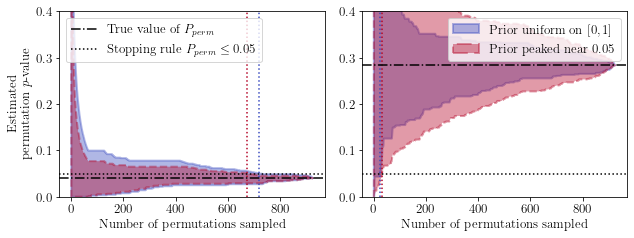

In [69]:
fig, ax = plt.subplots(1, 2, figsize = (9, 3.5))
plt.rc('font', size=13)

t = np.arange(1, num_trials + 1)

colors = cm.coolwarm(np.linspace(0, 1, 2))
ax[0].fill_between(t, np.array(lower_wor_unif1) / num_combinations, 
                 np.array(upper_wor_unif1)/ num_combinations, 
                 alpha = 0.4, color=colors[0], linestyle="-", lw=lw)
ax[0].fill_between(t, np.array(lower_wor_strong1) / num_combinations, 
                 np.array(upper_wor_strong1)/ num_combinations, alpha = 0.4,
                color=colors[1], lw=lw, linestyle="--")
ax[0].set(ylim=(0, 0.4))
ax[0].set(xlabel="Number of permutations sampled",
             ylabel="Estimated\npermutation $p$-value")
stopping_time_unif1 = np.where(upper_wor_unif1/num_combinations\
                               <= 0.05)[0][0]
print(stopping_time_unif1)
ax[0].axvline(x = stopping_time_unif1, 
            color=colors[0], linestyle = ":")
stopping_time_strong1 = np.where(upper_wor_strong1/num_combinations\
                                 <= 0.05)[0][0]
print(stopping_time_strong1)
ax[0].axvline(x = stopping_time_strong1, 
            color=colors[1], linestyle = ":")
true_p_perm = np.sum(exceed_test_stat1)/num_combinations
print(true_p_perm)
ax[0].axhline(np.sum(exceed_test_stat1)/num_combinations,
            color="black",
            linestyle="-.", label="True value of $P_{perm}$")
ax[0].axhline(0.05,
            color="black",
            linestyle=":", label="Stopping rule $P_{perm} \leq 0.05$")
ax[0].legend(loc = "upper left")

t = np.arange(1, num_trials + 1)

colors = cm.coolwarm(np.linspace(0, 1, 2))
ax[1].fill_between(t, np.array(lower_wor_unif2) / num_combinations, 
                 np.array(upper_wor_unif2)/ num_combinations, 
                 alpha = 0.4, label="Prior uniform on $[0,1]$", 
                   color=colors[0], linestyle="-", lw=lw)
ax[1].fill_between(t, np.array(lower_wor_strong2) / num_combinations, 
                 np.array(upper_wor_strong2)/ num_combinations, alpha = 0.4,
                 label="Prior peaked near 0.05", color=colors[1],
                   linestyle="--", lw=lw)
ax[1].set(ylim=(0, 0.4))
ax[1].set(xlabel="Number of permutations sampled")
stopping_time_unif2 = np.where(lower_wor_unif2/num_combinations\
                               > 0.05)[0][0]
ax[1].axvline(x = stopping_time_unif2, 
            color=colors[0], linestyle = ":")
stopping_time_strong2 = np.where(lower_wor_strong2/num_combinations\
                                 > 0.05)[0][0]
ax[1].axvline(x = stopping_time_strong2, 
            color=colors[1], linestyle = ":")
ax[1].axhline(np.sum(exceed_test_stat2)/num_combinations,
            color="black",
            linestyle="-.")
ax[1].axhline(0.05,
            color="black",
            linestyle=":")
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.savefig("../figures/uniformStrongPriorPermutation.pdf")


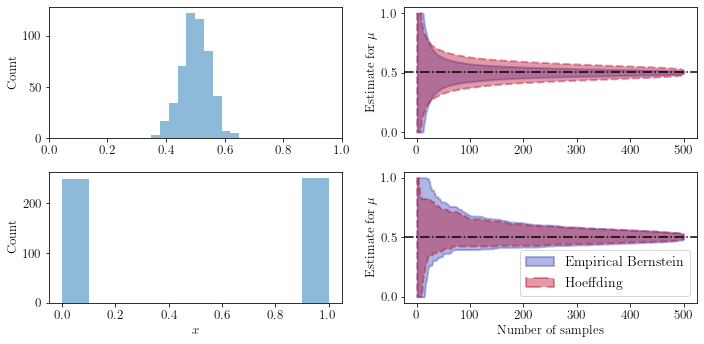

In [70]:
importlib.reload(cswor)
lw=2
a,b = 50,50
N = 500
t = np.arange(1, N+1)
x = np.random.beta(a, b, N)
mean_x = np.mean(x)
y = np.random.binomial(1, 1/2, N)
mean_y = np.mean(y)
n_t = np.repeat(1, N)
t = np.arange(0, len(x)) + 1
S_t = np.cumsum(x)  
Zstar = np.append([0], S_t)[0:len(S_t)] / (N-(t-1))  
Wstar = np.append([0], t)[0:len(S_t)] / (N-(t-1))  
mu_hat_t = (np.cumsum(Zstar) + S_t) / (t + np.cumsum(Wstar))  

alpha = 0.1


colors = cm.coolwarm(np.linspace(0, 1, 2))

l_eb_x, u_eb_x = cswor.predmix_empbern_wor(x, N=N, alpha=alpha,
                                           running_intersection=True)
l_h_x, u_h_x = cswor.predmix_hoeffding_wor(x, N=N, alpha=alpha, lower_bd=0, upper_bd=1)

l_eb_y, u_eb_y = cswor.predmix_empbern_wor(y, N=N, alpha=alpha, lambdas=None, lower_bd=0,upper_bd=1,
                                           running_intersection=True)

l_h_y, u_h_y = cswor.predmix_hoeffding_wor(y, N=N, alpha=alpha, lambdas=None, lower_bd=0, upper_bd=1,
                                           running_intersection=True)

fig, ax = plt.subplots(2, 2, figsize = (10, 5))
plt.rc('font', size=14)


ax[0][0].hist(x, alpha = 0.5)
ax[0][0].set_xlim(0, 1)
ax[0][0].set_ylabel("Count")
ax[1][0].hist(y, alpha = 0.5)
ax[1][0].set_xlabel("$x$")
ax[1][0].set_ylabel("Count")
ax[0][1].fill_between(t, l_eb_x, u_eb_x,
                     alpha = 0.4, 
                     label = "Bernstein",
                     color=colors[0], lw=lw)
ax[0][1].fill_between(t, l_h_x, u_h_x,
                     alpha = 0.4, 
                     label = "Hoeffding",
                     color=colors[1], linestyle="--", lw=lw)
ax[0][1].axhline(mean_x, linestyle = "-.", 
            color = "black")
ax[0, 1].set_ylabel("Estimate for $\mu$")
ax[1][1].fill_between(t, l_eb_y, u_eb_y,
                     alpha = 0.4, 
                     label = "Empirical Bernstein",
                     color=colors[0], lw=lw)
ax[1][1].fill_between(t, l_h_y, u_h_y,
                     alpha = 0.4, 
                     label = "Hoeffding",
                     color=colors[1], linestyle="--", lw=lw)
ax[1][1].axhline(mean_y, linestyle = "-.", 
            color = "black")
ax[1, 1].set_ylabel("Estimate for $\mu$")
ax[1, 1].set_xlabel("Number of samples")
ax[1, 1].legend(loc = "lower right")
plt.tight_layout()
plt.savefig("../figures/HoeffdingBernstein.pdf")

In [88]:
# P-values vs CS plot
importlib.reload(cswor)
alpha    = 0.05 
N        = 1000
Ta_true  = 650
# Uniform prior
BB_alpha = 1
BB_beta  = 1
n = np.ones(N)

x = np.append(np.ones(Ta_true), np.zeros(N - Ta_true))
np.random.shuffle(x)

# MLEs for Tb
t = np.arange(0, len(x)) + 1
S_t = np.cumsum(x)  
Zstar = np.append([0], S_t)[0:len(S_t)] / (N-(t-1))  
Wstar = np.append([0], t)[0:len(S_t)] / (N-(t-1))  
Ta_hats = N*(np.cumsum(Zstar) + S_t) / (t + np.cumsum(Wstar))
CIs_lower_a, CIs_upper_a = cswor.BBHG_confseq(x, N, BB_alpha, BB_beta,
                                           alpha = alpha,
                                           running_intersection = True)

CIs_lower_a = np.array(CIs_lower_a)
CIs_upper_a = np.array(CIs_upper_a)

# Create confidence sequence plots

nulls=((650, 350), (600, 400), (550, 450))
pval_list=[None]*len(nulls)
DM_x = np.vstack((x, n-x))
for i in np.arange(0, len(nulls)):
    pval_list[i]=cswor.pval_from_martingale(
                 cswor.DMHG_martingale(DM_x,DM_alpha=[1, 1],
                                   T_null=nulls[i]), running_min=True)


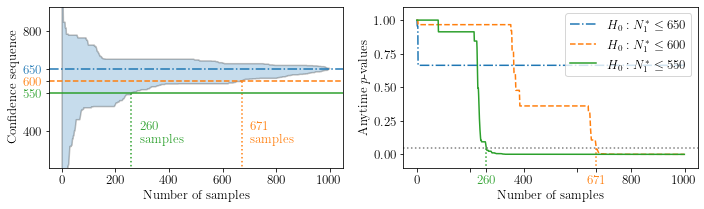

In [90]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3.1))
lw=1.5
plt.rc('font', size=13)
colors=("tab:blue", "tab:orange", "tab:green")
linestyles=("-.", "--", "-")
ax[0].fill_between(t, CIs_lower_a, CIs_upper_a,
                   alpha =0.25, 
                   facecolor="tab:blue", linestyle="-", 
                   lw=lw, edgecolor="black")

stopping_times=[None]*3
for i in np.arange(0,len(nulls)):
    ax[0].axhline(nulls[i][0], 
                  linestyle=linestyles[i],
                  color=colors[i], lw=lw)
    ax[1].plot(pval_list[i], 
               color=colors[i],
               linestyle=linestyles[i],
               lw=lw, label="$H_0: N_1^* \leq "+str(nulls[i][0])+"$")
    # Add vertical line for when the sampling can stop
    if any(CIs_lower_a > nulls[i][0]):
        stopping_time = np.where(CIs_lower_a > nulls[i][0])[0][0]
        stopping_times[i]=stopping_time
        ax[0].vlines(x=stopping_time, color=colors[i],
                      linestyle=":", 
                      ymin=0, ymax=nulls[i][0], lw=lw)
        ax[0].text(x=stopping_time + 30, y = 350,
                   s=str(stopping_time)+"\nsamples",
                   color=colors[i])
        ax[1].vlines(x=stopping_time, color=colors[i],
                      linestyle=":", ymin=-1, ymax=alpha, lw=lw)

ax[0].set(xlabel = "Number of samples", 
             ylabel = "Confidence sequence")

yticks=np.append(np.arange(0, 1001, step=200), [550, 650])
ax[0].set_yticks(yticks)
ax[0].get_yticklabels()[3].set_color("tab:orange")
ax[0].get_yticklabels()[-2].set_color("tab:green")
ax[0].get_yticklabels()[-1].set_color("tab:blue")
ax[0].set_ylim(250, 900)

ax[1].set(xlabel="Number of samples",
          ylabel="Anytime $p$-values")
ax[1].axhline(alpha, color="grey", 
              linestyle=":", lw=lw)
xticks=np.append(np.arange(0, 1001, step=200), [stopping_times[2], stopping_times[1]])
xticklabels=[str(t) if (t!=200 and t!=600) else "" for t in xticks]

ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticklabels)
ax[1].get_xticklabels()[-2].set_color("tab:green")
ax[1].get_xticklabels()[-1].set_color("tab:orange")
ax[1].set_ylim(-0.1, 1.1)
    
ax[1].legend(loc = "upper right")

plt.tight_layout()
plt.savefig("../figures/CSvsPval.pdf")
plt.show()


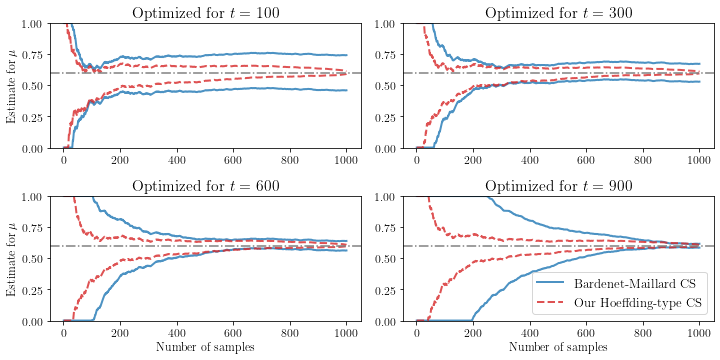

In [45]:
importlib.reload(cswor)
N = 1000
x = np.random.binomial(1, 0.6, N)
emp_mean=np.mean(x)
n_t = np.repeat(1, N)
t = np.arange(0, len(x)) + 1
mu_hat_t_x = np.cumsum(x) / t

opt_times=[100, 300, 600, 900]

ax=[None]*4
fig, ([ax[0], ax[1]], [ax[2], ax[3]]) = plt.subplots(2, 2, figsize = (10, 5))
plt.rc('font', size=13)

lw=2

for i in np.arange(0, 4):
    lower_CI_BM, upper_CI_BM = cswor.hoeffding_wor_BM_stitch(x, lower_bd = 0,
                                                 upper_bd = 1,
                                                 N = N, epoch_times = [opt_times[i]],
                                                 alpha = 0.05)
    lower_CI_WSR, upper_CI_WSR = cswor.hoeffding_wor_lc_stitch(x, lower_bd=0, upper_bd=1,
                                                        t_opts=[opt_times[i]], N=N, alpha=0.05)
    
    
    ax[i].plot(t, lower_CI_BM,
                 alpha = 0.8, color="tab:blue",
                 label="Bardenet-Maillard CS", linestyle="-",lw=lw)
    ax[i].plot(t, upper_CI_BM,
               alpha = 0.8, color="tab:blue", linestyle="-",lw=lw)
    ax[i].plot(t, lower_CI_WSR,
                 alpha = 0.8, color="tab:red", linestyle="--",lw=lw,
                 label="Our Hoeffding-type CS")
    ax[i].plot(t, upper_CI_WSR,
               alpha = 0.8, color="tab:red", linestyle="--",lw=lw)
    ax[i].set_title("Optimized for $t=" + str(opt_times[i]) + "$")
    
    
    ax[i].axhline(emp_mean, color="grey", linestyle="-.")
    
    ax[i].set_ylim(0,1)
    
plt.tight_layout()
ax[0].set_ylabel("Estimate for $\mu$")
ax[2].set_ylabel("Estimate for $\mu$")
ax[2].set_xlabel("Number of samples")
ax[3].set_xlabel("Number of samples")
ax[3].legend(loc="lower right")


plt.savefig("../figures/HSvsOurs.pdf")

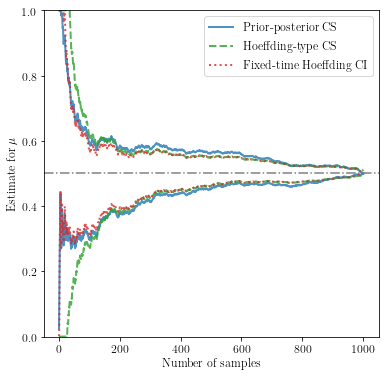

In [54]:
importlib.reload(cswor)
lw=2
x = np.append(np.ones(500), np.zeros(500))
np.random.shuffle(x)
N=len(x)
emp_mean=np.mean(x)
n_t = np.repeat(1, N)
t = np.arange(0, len(x)) + 1
mu_hat_t_x = np.cumsum(x) / t

lower_CI_PPR, upper_CI_PPR = cswor.BBHG_confseq(x, N=N, 
                                             n=np.ones(N), 
                                             BB_alpha=1, BB_beta=1, 
                                             alpha=0.05)

lower_CI_WSR, upper_CI_WSR = cswor.hoeffding_wor(x, lower_bd=0, upper_bd=1,
                                                 t_opts=[500],
                                                 N=N, alpha=0.05)

lower_CI_WSR_fixed, upper_CI_WSR_fixed = cswor.hoeffding_wor_ci_seq(x, lower_bd=0, upper_bd=1,
                                                                    N=N, alpha=0.05)

plt.figure(figsize=(6,6))
plt.rc('font', size=12)
plt.plot(t, lower_CI_PPR/N, color="tab:blue", lw=lw,
         alpha=0.8, label="Prior-posterior CS")
plt.plot(t, lower_CI_WSR, color="tab:green", linestyle="--", lw=lw,
         alpha=0.8, label="Hoeffding-type CS")
plt.plot(t, lower_CI_WSR_fixed, color="tab:red", lw=lw,
         alpha=0.8, label="Fixed-time Hoeffding CI", linestyle=":")

plt.plot(t, upper_CI_PPR/N, color="tab:blue",lw=lw,
         alpha=0.8)
plt.plot(t, upper_CI_WSR, color="tab:green", linestyle="--",lw=lw,
         alpha=0.8)
plt.plot(t, upper_CI_WSR_fixed, color="tab:red", linestyle=":",lw=lw,
         alpha=0.8)

plt.axhline(emp_mean, color="grey", linestyle="-.")
plt.ylim(0, 1)
plt.xlabel("Number of samples")
plt.ylabel("Estimate for $\mu$")
plt.legend(loc = "best")

plt.savefig("../figures/TimeUniformVsFixedTime.pdf")

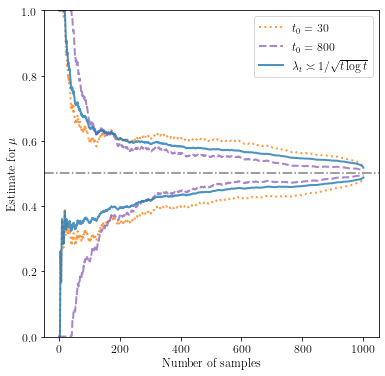

In [55]:
alpha=0.05
t = np.arange(1, len(x) + 1)

l_early, u_early = cswor.hoeffding_wor(x, N=N, alpha=alpha, 
                                       t_opts=[30], lower_bd=0, 
                                       upper_bd=1)

l_late, u_late = cswor.hoeffding_wor(x, N=N, alpha=alpha, 
                                     t_opts=[900], lower_bd=0, 
                                     upper_bd=1)
l_spread, u_spread = cswor.predmix_hoeffding_wor(x, N=N,
                                                 alpha=alpha, 
                                                 lower_bd=0, 
                                                 upper_bd=1)

plt.figure(figsize=(6,6))
plt.rc('font', size=12)
plt.plot(t, l_early, color="tab:orange", linestyle=":", lw=lw,
         alpha=0.8, label="$t_0 = 30$")
plt.plot(t, l_late, color="tab:purple", linestyle="--", lw=lw,
         alpha=0.8, label="$t_0 = 800$")
plt.plot(t, l_spread, color="tab:blue", linestyle="-", lw=lw,
         alpha=0.8, label=r'$\lambda_t \asymp 1 / \sqrt{t \log t}$')

plt.plot(t, u_early, color="tab:orange", linestyle=":", lw=lw,
         alpha=0.8)
plt.plot(t, u_late, color="tab:purple", linestyle="--", lw=lw,
         alpha=0.8)
plt.plot(t, u_spread, color="tab:blue", linestyle="-", lw=lw,
         alpha=0.8)

plt.axhline(emp_mean, color="grey", linestyle="-.")
plt.ylim(0, 1)
plt.xlabel("Number of samples")
plt.ylabel("Estimate for $\mu$")
plt.legend(loc = "best")

plt.savefig('../figures/scheduleVsFixed.pdf')

In [58]:

importlib.reload(cswor)
a,b = 5,2
N = 10000
ones=math.floor(N/2)
t = np.arange(1, N+1)
x = np.append(np.ones(ones), np.zeros(N-ones))
np.random.shuffle(x)
n_t = np.repeat(1, N)
t = np.arange(0, len(x)) + 1
S_t = np.cumsum(x)  
Zstar = np.append([0], S_t)[0:len(S_t)] / (N-(t-1))  
Wstar = np.append([0], t)[0:len(S_t)] / (N-(t-1))  
mu_hat_t = (np.cumsum(Zstar) + S_t) / (t + np.cumsum(Wstar))  

nsim=1000
miscoverage_eb=np.zeros((nsim, N))
miscoverage_h=np.zeros((nsim, N))
miscoverage_PPR=np.zeros((nsim,N))
alpha=0.1

for i in np.arange(0, nsim):
    
    np.random.shuffle(x)
    emp_mean=np.mean(x)
    lower_eb, upper_eb = cswor.emp_bern_wor(x, lower_bd = 0,
                                                  upper_bd = 1,
                                                  V_t_opts = [3000/4],
                                                  N=N, alpha=alpha,
                                                  running_intersection=True)
    lower_h, upper_h = cswor.hoeffding_wor(x, lower_bd=0,
                                           upper_bd=1,
                                           N=N, alpha=alpha,
                                           t_opts=[3000],
                                           running_intersection=True)
    PPR_mart=cswor.DMHG_martingale(np.vstack((x,n_t-x)), DM_alpha=[1, 1], 
                                T_null=(np.sum(x), N-np.sum(x)))
    pval = cswor.pval_from_martingale(PPR_mart, running_min=True)
    
    miscoverage_eb[i,] = np.logical_or(lower_eb>emp_mean,upper_eb<emp_mean)
    miscoverage_h[i,] = np.logical_or(lower_h>emp_mean,upper_h<emp_mean)
    miscoverage_PPR[i,] = pval < alpha
    

cumul_reject_eb_discrete=np.sum(miscoverage_eb,axis=0)/nsim
cumul_reject_h_discrete=np.sum(miscoverage_h,axis=0)/nsim
cumul_reject_PPR_discrete=np.sum(miscoverage_PPR,axis=0)/nsim


In [59]:
importlib.reload(cswor)
a,b = 1,1
N = 10000
ones=math.floor(N/2)
t = np.arange(1, N+1)
x = np.random.beta(a, b, N)
np.random.shuffle(x)
n_t = np.repeat(1, N)
t = np.arange(0, len(x)) + 1
S_t = np.cumsum(x)  
Zstar = np.append([0], S_t)[0:len(S_t)] / (N-(t-1))  
Wstar = np.append([0], t)[0:len(S_t)] / (N-(t-1))  
mu_hat_t = (np.cumsum(Zstar) + S_t) / (t + np.cumsum(Wstar))  

nsim=1000
miscoverage_eb=np.zeros((nsim, N))
miscoverage_h=np.zeros((nsim, N))
miscoverage_PPR=np.zeros((nsim,N))
alpha=0.1

for i in np.arange(0, nsim):
    np.random.shuffle(x)
    emp_mean=np.mean(x)
    lower_eb, upper_eb = cswor.emp_bern_wor(x, lower_bd = 0,
                                                  upper_bd = 1,
                                                  V_t_opts = [3000/4],
                                                  N=N, alpha=alpha,
                                                  running_intersection=True)
    lower_h, upper_h = cswor.hoeffding_wor(x, lower_bd=0,
                                           upper_bd=1,
                                           N=N, alpha=alpha,
                                           t_opts=[3000],
                                           running_intersection=True)
    pval = cswor.pval_from_martingale(PPR_mart, running_min=True)
    
    miscoverage_eb[i,] = np.logical_or(lower_eb>emp_mean,upper_eb<emp_mean)
    miscoverage_h[i,] = np.logical_or(lower_h>emp_mean,upper_h<emp_mean)

    


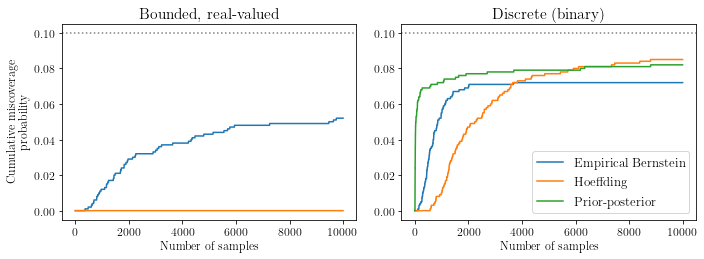

In [60]:
cumul_reject_eb_continuous=np.sum(miscoverage_eb,axis=0)/nsim
cumul_reject_h_continuous=np.sum(miscoverage_h,axis=0)/nsim

fig, ax = plt.subplots(1, 2, figsize = (10, 3.8))
plt.rc('font', size=13)

ax[1].plot(cumul_reject_eb_discrete[0:(N-1)],label="Empirical Bernstein")
ax[1].plot(cumul_reject_h_discrete[0:(N-1)], label="Hoeffding")
ax[1].plot(cumul_reject_PPR_discrete[0:(N-1)], label="Prior-posterior")
ax[1].set_xlabel("Number of samples")
ax[1].legend(loc="best")
ax[1].set_title("Discrete (binary)")

ax[1].axhline(alpha, color="grey", linestyle=":")

ax[0].set_ylabel("Cumulative miscoverage\nprobability")
ax[0].plot(cumul_reject_eb_continuous[0:(N-1)],label="Empirical Bernstein")
ax[0].plot(cumul_reject_h_continuous[0:(N-1)], label="Hoeffding")
ax[0].set_xlabel("Number of samples")

ax[0].axhline(alpha, color="grey", linestyle=":")
ax[0].set_title("Bounded, real-valued")
plt.tight_layout()
plt.savefig("../figures/cumulativeRejectionProb.pdf")


# Computation time

In [61]:
N = 1000

x = np.append(np.ones(int(N/2)), np.zeros(int(N/2)))
np.random.shuffle(x)
nsim = 100
PPR_times = np.zeros(nsim)
H_times = np.zeros(nsim)
EB_times = np.zeros(nsim)
for i in range(nsim):
    start = time.time()
    l, u = cswor.BBHG_confseq(x, n = np.ones(N), N = N, BB_alpha=1, BB_beta=1)
    end = time.time()
    PPR_times[i] = end-start
    start = time.time()
    l, u = cswor.predmix_hoeffding_wor(x, N=N)
    end = time.time()
    H_times[i] = end-start
    start = time.time()
    l, u = cswor.predmix_empbern_wor(x, N=N)
    end = time.time()
    EB_times[i] = end-start
    print('Completed ' + str(i+1) + ' out of ' + str(nsim))

Completed 1 out of 100
Completed 2 out of 100
Completed 3 out of 100
Completed 4 out of 100
Completed 5 out of 100
Completed 6 out of 100
Completed 7 out of 100
Completed 8 out of 100
Completed 9 out of 100
Completed 10 out of 100
Completed 11 out of 100
Completed 12 out of 100
Completed 13 out of 100
Completed 14 out of 100
Completed 15 out of 100
Completed 16 out of 100
Completed 17 out of 100
Completed 18 out of 100
Completed 19 out of 100
Completed 20 out of 100
Completed 21 out of 100
Completed 22 out of 100
Completed 23 out of 100
Completed 24 out of 100
Completed 25 out of 100
Completed 26 out of 100
Completed 27 out of 100
Completed 28 out of 100
Completed 29 out of 100
Completed 30 out of 100
Completed 31 out of 100
Completed 32 out of 100
Completed 33 out of 100
Completed 34 out of 100
Completed 35 out of 100
Completed 36 out of 100
Completed 37 out of 100
Completed 38 out of 100
Completed 39 out of 100
Completed 40 out of 100
Completed 41 out of 100
Completed 42 out of 100
C

In [22]:
print("Means")
print(np.mean(PPR_times))
print(np.mean(H_times))
print(np.mean(EB_times))

print("Std devs")
print(np.sqrt(np.var(PPR_times)))
print(np.sqrt(np.var(H_times)))
print(np.sqrt(np.var(EB_times)))

Means
0.29995792150497436
0.00021180152893066407
0.00023040533065795898
Std devs
0.01221280059601127
2.86135576219768e-05
3.8855234567009364e-05


In [23]:
print(sys.version)

3.8.3 (default, Jul 13 2020, 22:15:09) 
[Clang 11.0.3 (clang-1103.0.32.62)]
